* **기후정보학및실습** HW5
조선아(2173112)

In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 라이브러리 불러오기
import warnings # 불필요한 에러메시지 축소
warnings.simplefilter(action='ignore', category=FutureWarning)
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import normaltest

1. As for HW#4, read the temperature data in “/content/drive/My Drive/Data/ASOS_108” from  1951-2023. Make it daily.

In [3]:
directory = '/content/drive/MyDrive/2024 기후정보학및실습/ASOS_108/'
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]
# 설정한 디렉토리 안에서 .csv 파일 이름을 모두 읽어옴
csv_files.sort()
dataframes = []
for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path, encoding='cp949') # 경로의 데이터를 차례대로 읽어옴
    dataframes.append(df)

combined_df = pd.concat(dataframes) # 읽어온 모든 데이터를 하나의 데이터프레임으로 합침
combined_df['일시'] = pd.to_datetime(combined_df['일시']) # '일시' 열을 pandas가 읽을 수 있는 datetime 형식으로 변환
data = combined_df.sort_values(by='일시').reset_index(drop=True) # 일시에 대해 정렬한 다음 index 리셋

In [4]:
# daily averages 구하기: 각 날짜의 0~24시 평균 기온 구하기
data['날짜'] = data['일시'].dt.date # 날짜 추출
daily_temp = data.groupby('날짜')['기온(°C)'].mean() # 평균 기온 연산
daily_temp_df = daily_temp.to_frame().reset_index()
daily_temp_df['날짜'] = pd.to_datetime(daily_temp_df['날짜'])
daily_temp_df['Month'] = daily_temp_df['날짜'].dt.month
daily_temp_df

,날짜,기온(°C),Month
0,1951-12-01,1.533333,12
1,1951-12-02,3.500000,12
2,1951-12-03,4.066667,12
3,1951-12-04,1.966667,12
4,1951-12-05,0.866667,12
...,...,...,...
26293,2023-12-27,1.508333,12
26294,2023-12-28,1.137500,12
26295,2023-12-29,1.541667,12
26296,2023-12-30,0.458333,12


2. Subsample the data for DJF, MAM, JJA, and SON.

In [5]:
# 함수 제작: 동일 실행 반복 시 코드 간결화를 위함

# subsample 함수 정의: 계절별로 구분한 dataframe 리턴
def split_seasons(daily_df):
    DJF = daily_df[(daily_df['Month'] == 12) | (daily_df['Month'] == 1) | (daily_df['Month'] == 2)]
    MAM = daily_df[(daily_df['Month'] == 3) | (daily_df['Month'] == 4) | (daily_df['Month'] == 5)]
    JJA = daily_df[(daily_df['Month'] == 6) | (daily_df['Month'] == 7) | (daily_df['Month'] == 8)]
    SON = daily_df[(daily_df['Month'] == 9) | (daily_df['Month'] == 10) | (daily_df['Month'] == 11)]
    DJF = DJF.drop('Month', axis=1)
    MAM = MAM.drop('Month', axis=1)
    JJA = JJA.drop('Month', axis=1)
    SON = SON.drop('Month', axis=1)
    return DJF, MAM, JJA, SON

# 기온 데이터에 함수를 적용
DJF_temp, MAM_temp, JJA_temp, SON_temp = split_seasons(daily_temp_df)

3. Plot the histogram/bar charts for each season.

In [6]:
# Histogram 그리는 함수 정의
def plot_season_histogram(df, season_name, ax, color, target):
    if ax is None:
        ax = plt.gca()
    if target == '기온(°C)': # 기온 히스토그램
        sns.histplot(df[target], bins=range(int(daily_temp_df[target].min())-1, int(daily_temp_df[target].max()) + 2),
                 alpha=0.7, ax=ax, color=color, label=season_name)
        ax.set_xlabel('Temperature (°C)', fontsize=12)
    else:  # 풍속 히스토그램
        sns.histplot(df[target], bins=np.arange(int(daily_wspd_df[target].min())-1, int(daily_wspd_df[target].max()) + 2, 0.2),
                 alpha=0.7, ax=ax, color=color, label=season_name)
        ax.set_xlabel('Wind speed (m/s)', fontsize=12)
    ax.set_title(season_name, fontsize=12, pad=5)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_ylim(0, 1000)

colors = sns.color_palette('husl', 4)

# 각 season에 대한 label을 포함하는 데이터프레임 추가 생성
merged_temp = pd.DataFrame({
    "DJF": DJF_temp['기온(°C)'],
    "MAM": MAM_temp['기온(°C)'],
    "JJA": JJA_temp['기온(°C)'],
    "SON": SON_temp['기온(°C)'],
})

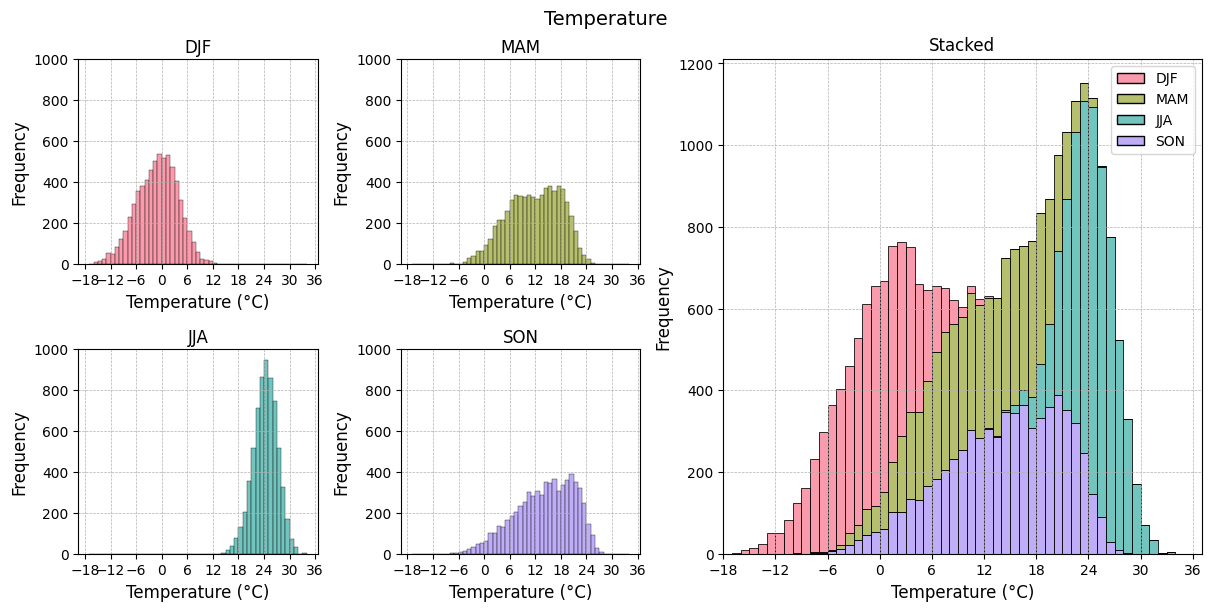

In [19]:
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
spec = fig.add_gridspec(2, 4)

# (왼쪽 4개) 계절별 히스토그램: 히스토그램 그리기 함수를 불러옴
ax00 = fig.add_subplot(spec[0, 0])
plot_season_histogram(DJF_temp, 'DJF', ax00, colors[0], '기온(°C)')
ax10 = fig.add_subplot(spec[0, 1])
plot_season_histogram(MAM_temp, 'MAM', ax10, colors[1], '기온(°C)')
ax20 = fig.add_subplot(spec[1, 0])
plot_season_histogram(JJA_temp, 'JJA', ax20, colors[2], '기온(°C)')
ax30 = fig.add_subplot(spec[1, 1])
plot_season_histogram(SON_temp, 'SON', ax30, colors[3], '기온(°C)')
# (오른쪽 1개) 누적 히스토그램 그리기 (multiple="stack")
ax_big = fig.add_subplot(spec[:, 2:])
sns.histplot(data=merged_temp, multiple="stack", bins=range(int(daily_temp_df['기온(°C)'].min())-1,
                                                          int(daily_temp_df['기온(°C)'].max()) + 2),
                                                          alpha=0.7, palette=colors)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlim(-18, 37)
plt.xticks(np.arange(-18, 37, 6))
plt.title("Stacked")
plt.xlabel("Temperature (°C)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

fig.suptitle('Temperature', fontsize=14)
plt.show()

4. Find and plot the Gaussian distributions associated with the temperatures of each season using their means and standard deviations.

In [8]:
# Histogram (density) + Gaussian distributions 그리는 함수 정의
def plot_season_histogram_with_gaussian(df, season_name, ax, color, target):
    if ax is None:
        ax = plt.gca()
    if target == '기온(°C)': # 기온 히스토그램
        sns.histplot(df[target], bins=np.arange(int(daily_temp_df[target].min())-1, int(daily_temp_df[target].max()) + 2),
                 alpha=0.7, ax=ax, color=color, stat="density")
        ax.set_xlabel('Temperature (°C)', fontsize=12)
        ax.set_ylim(0, 0.15)
    else: # 풍속 히스토그램
        sns.histplot(df[target], bins=np.arange(int(daily_wspd_df[target].min())-1, int(daily_wspd_df[target].max()) + 2, 0.2),
                 alpha=0.7, ax=ax, color=color, stat="density")
        ax.set_xlabel('Wind speed (m/s)', fontsize=12)
        ax.set_ylim(0, 0.65)
    ax.set_title(season_name, fontsize=12, pad=5)
    ax.set_ylabel('Density', fontsize=12)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    # Gaussian distribution 그리기
    mean = df[target].mean() # 데이터의 계절별 평균 연산
    std = df[target].std() # 데이터의 계절별 표준편차 연산
    x = np.linspace(df[target].min(), df[target].max(), 100)
    gaussian = norm.pdf(x, mean, std) # Gaussian distribution 계산
    ax.plot(x, gaussian, color='red', linestyle='--', label='Gaussian')

    median = df[target].median()
    ax.axvline(mean, color='red', linestyle='--', linewidth=0.7, label='Mean') # mean 표시 (수직선)
    ax.axvline(median, color='blue', linestyle='--', linewidth=0.7, label='Median') # median 표시 (수직선)
    ax.legend()


    ax.legend()

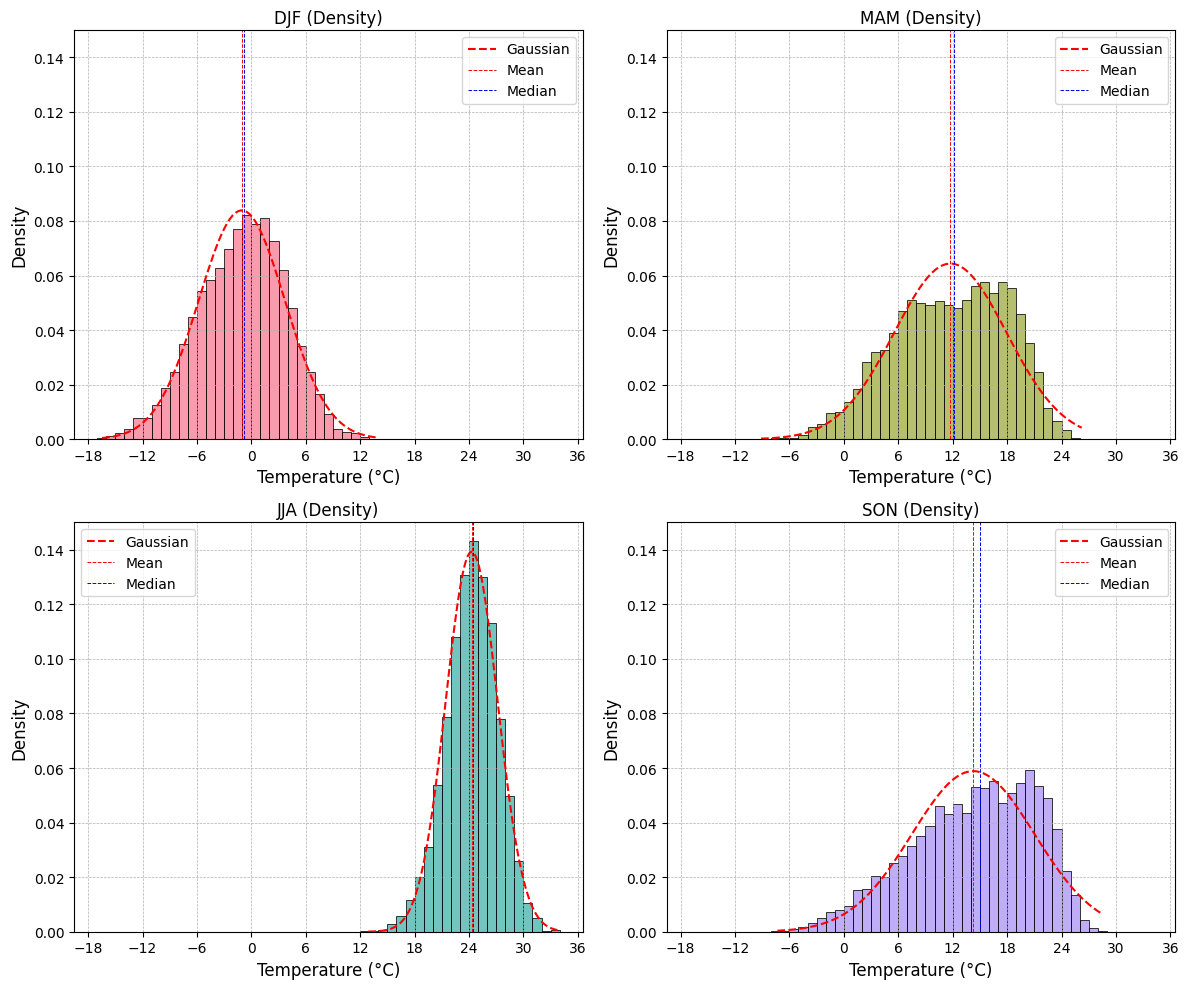

In [9]:
# Histogram (density) + Gaussian distributions 그리기 (Temperature)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
plot_season_histogram_with_gaussian(DJF_temp, 'DJF (Density)', axs[0, 0], colors[0], '기온(°C)')
plot_season_histogram_with_gaussian(MAM_temp, 'MAM (Density)', axs[0, 1], colors[1], '기온(°C)')
plot_season_histogram_with_gaussian(JJA_temp, 'JJA (Density)', axs[1, 0], colors[2], '기온(°C)')
plot_season_histogram_with_gaussian(SON_temp, 'SON (Density)', axs[1, 1], colors[3], '기온(°C)')
plt.tight_layout()
plt.show()

5. Are Gaussians a good fit for the distributions?


*   Histogram (density) + Gaussian distributions 그림에 따르면 계절별(일별) 기온 데이터는 대체로 정규분포를 따르지 않는다.
*   봄(MAM)과 가을(SON): (Mean) < (Median)이고, 데이터의 꼬리가 왼쪽으로 길다.
*   겨울(DJF)과 여름(JJA): 평균과 중앙값이 유사하고, 데이터의 꼬리가 비교적 왼쪽으로 길다.
*   전 계절에 대한 히스토그램이 보이는 bimodal distribution에는(HW#4) 겨울과 여름의 분포가 상당 부분 기여했을 것이다.

6. Repeat 1)-5) for wind speed.

In [10]:
# daily averages 구하기: 각 날짜의 0~24시 평균 풍속 구하기
data['날짜'] = data['일시'].dt.date # 날짜 추출
daily_wspd = data.groupby('날짜')['풍속(m/s)'].mean() # 평균 풍속 연산
daily_wspd_df = daily_wspd.to_frame().reset_index()
daily_wspd_df['날짜'] = pd.to_datetime(daily_wspd_df['날짜'])
daily_wspd_df['Month'] = daily_wspd_df['날짜'].dt.month
DJF_wspd, MAM_wspd, JJA_wspd, SON_wspd = split_seasons(daily_wspd_df) # 풍속 데이터에 계절 분리 함수를 적용

merged_wspd = pd.DataFrame({
    "DJF": DJF_wspd['풍속(m/s)'],
    "MAM": MAM_wspd['풍속(m/s)'],
    "JJA": JJA_wspd['풍속(m/s)'],
    "SON": SON_wspd['풍속(m/s)'],
})

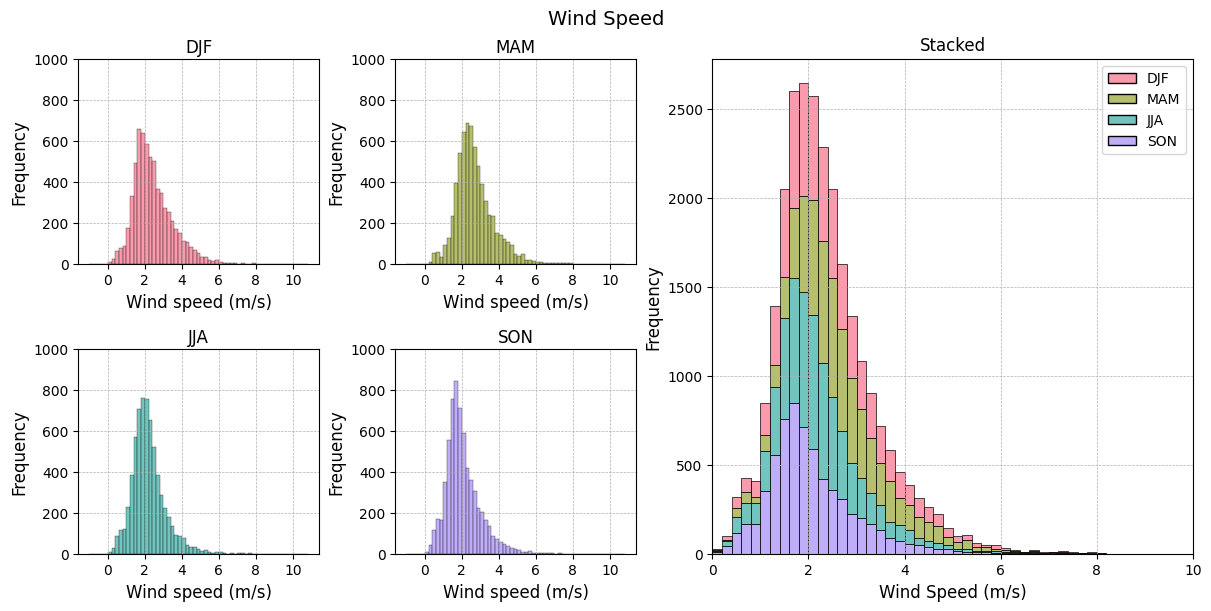

In [18]:
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
spec = fig.add_gridspec(2, 4)

# (왼쪽 4개) 계절별 히스토그램: 히스토그램 그리기 함수를 불러옴
ax00 = fig.add_subplot(spec[0, 0])
plot_season_histogram(DJF_wspd, 'DJF', ax00, colors[0], '풍속(m/s)')
ax10 = fig.add_subplot(spec[0, 1])
plot_season_histogram(MAM_wspd, 'MAM', ax10, colors[1], '풍속(m/s)')
ax20 = fig.add_subplot(spec[1, 0])
plot_season_histogram(JJA_wspd, 'JJA', ax20, colors[2], '풍속(m/s)')
ax30 = fig.add_subplot(spec[1, 1])
plot_season_histogram(SON_wspd, 'SON', ax30, colors[3], '풍속(m/s)')
# (오른쪽 1개) 누적 히스토그램 그리기 (multiple="stack")
ax_big = fig.add_subplot(spec[:, 2:])
sns.histplot(data=merged_wspd, multiple="stack", bins=np.arange(int(daily_wspd_df['풍속(m/s)'].min())-1,
                                                          int(daily_wspd_df['풍속(m/s)'].max()) + 2, 0.2),
                                                          alpha=0.7, palette=colors)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlim(0, 10)
plt.xticks(np.arange(0, 11, 2))
plt.title("Stacked")
plt.xlabel("Wind Speed (m/s)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

fig.suptitle('Wind Speed', fontsize=14)
plt.show()

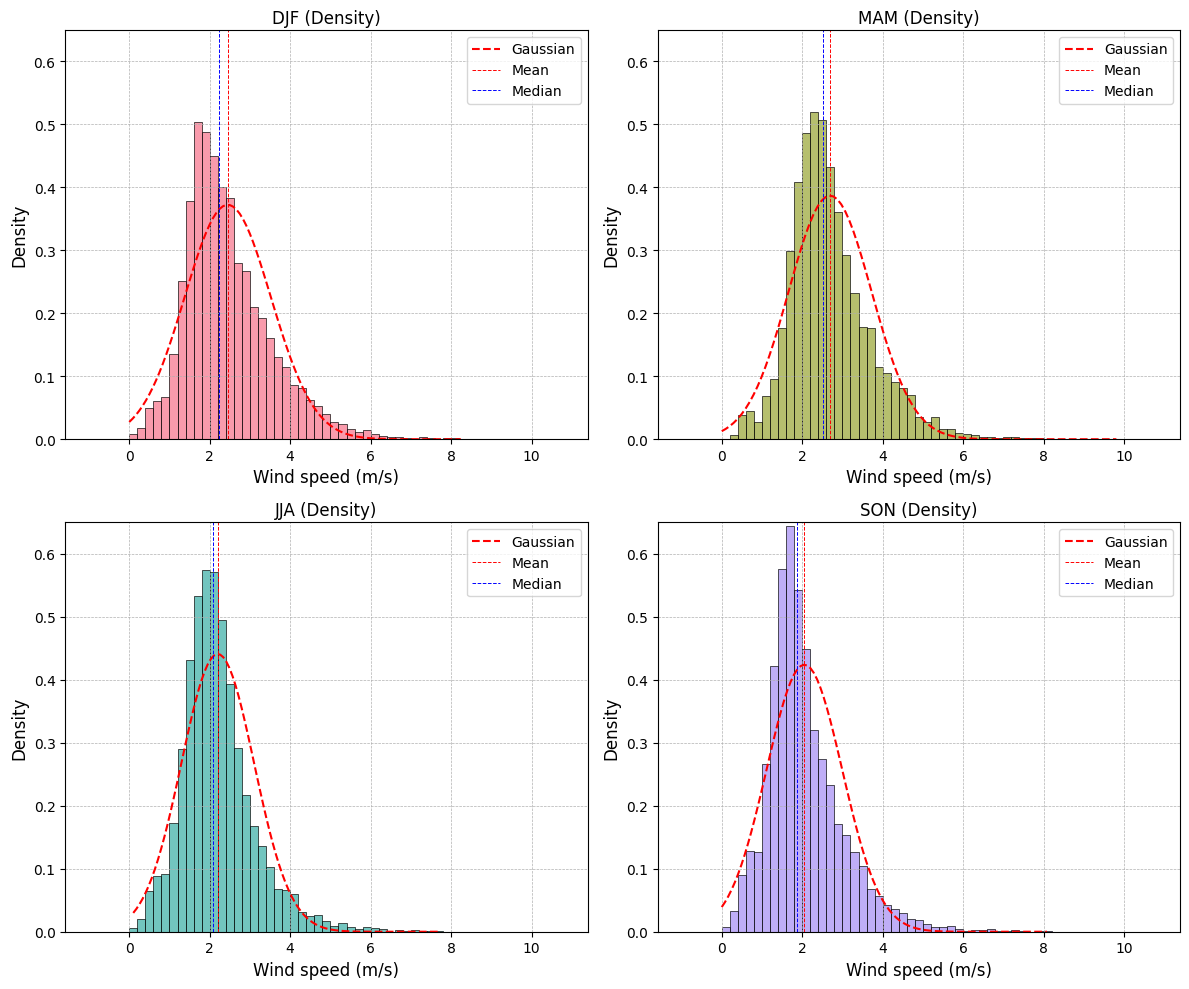

In [12]:
# Histogram (density) + Gaussian distributions 그리기 (Wind speed)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
plot_season_histogram_with_gaussian(DJF_wspd, 'DJF (Density)', axs[0, 0], colors[0], '풍속(m/s)')
plot_season_histogram_with_gaussian(MAM_wspd, 'MAM (Density)', axs[0, 1], colors[1], '풍속(m/s)')
plot_season_histogram_with_gaussian(JJA_wspd, 'JJA (Density)', axs[1, 0], colors[2], '풍속(m/s)')
plot_season_histogram_with_gaussian(SON_wspd, 'SON (Density)', axs[1, 1], colors[3], '풍속(m/s)')
plt.tight_layout()
plt.show()

*   Histogram (density) + Gaussian distributions 그림에 따르면 계절별(일별) 풍속 데이터는 대체로 정규분포를 따르지 않는다.
*   모든 계절에서 (Mean) > (Median)이고, 데이터의 꼬리가 오른쪽으로 길다.

---

> **(Supplementary analysis) Shapiro-Wilk tests**



*   정규성에 대한 수치적 검정 방법
*   ``` scipy.stats``` 라이브러리의 ``` normaltest``` 활용
*   귀무가설(H0): 검정에 사용한 데이터가 정규분포를 **따른다.**
*   모든 계절의 기온/풍속 데이터에 대한 검정 결과, 매우 높은 신뢰수준에 대해 귀무가설을 기각할 수 있으므로 모두 정규성을 지니지 않았다고 할 수 있다.



In [13]:
from scipy.stats import normaltest

def test_and_print_normality(data, column_name, season_name):
    _, p_value = normaltest(data[~data.isnull()])
    print("{} - {} - p-value: {}".format(season_name, column_name, p_value))

def test_and_print_seasonal_normality(temp_df, wspd_df):
    columns = ['기온(°C)', '풍속(m/s)']
    seasons = ['DJF', 'MAM', 'JJA', 'SON']

    for season in seasons:
        print("Testing normality for season:", season)
        print("------------------------")
        data1 = temp_df[season]
        data2 = wspd_df[season]
        test_and_print_normality(data1, columns[0], season)
        test_and_print_normality(data2, columns[1], season)
        print("\n")

test_and_print_seasonal_normality(merged_temp, merged_wspd)

Testing normality for season: DJF
------------------------
DJF - 기온(°C) - p-value: 3.192496407424089e-13
DJF - 풍속(m/s) - p-value: 3.9434278756891206e-237


Testing normality for season: MAM
------------------------
MAM - 기온(°C) - p-value: 3.254637413652071e-85
MAM - 풍속(m/s) - p-value: 2.613858705539389e-307


Testing normality for season: JJA
------------------------
JJA - 기온(°C) - p-value: 2.091304223353044e-13
JJA - 풍속(m/s) - p-value: 0.0


Testing normality for season: SON
------------------------
SON - 기온(°C) - p-value: 2.1196100457330273e-71
SON - 풍속(m/s) - p-value: 0.0




---

> **(Supplementary analysis) datasets**

1. 규격에서 벗어난 데이터가 존재한다.
+   Length of ```SURFACE_ASOS_108_HR_2011_2020_2021.csv```: 87671 (파일 크기 10배, 제거하고 분석하였음)
+  파일당 약 8760~8784(윤년)개의 시점을 지님
    *   예외: 30분 간격 관측이 일부 존재하는 파일 2개
    *   예외 1: Length of ```SURFACE_ASOS_108_HR_2008_2008_2015.csv```: 8793 (+9)
    *   예외 2: Length of ```SURFACE_ASOS_108_HR_2009_2009_2015.csv```: 8766 (+6)


2. 일부 시간별 데이터의 결측이 일평균에 영향을 미칠 수 있다는 점을 유의하여 위 결과들을 해석해야 한다.


+  결측 데이터의 분포
    *  1962년 이전 데이터의 경우, 관측이 다수 누락되어 있어 1951-2023 데이터 분석에서 그 비중이 다소 작음
    *  시점에 대한 결측은 다수인 반면, 일평균을 구할 경우 결측치의 개수가 급격히 감소함
    * 따라서, 특정 시기에는 하루 중 특정 시각의 데이터가 그날의 기온과 풍속을 대표할 가능성이 있음
        -   결측(기온): 2000년 이전까지 다수 존재 (특히, 1951-1953, 1963-1970 결측 다수 존재)
        -   연중 시간별 결측치의 분포(기온): 특정 시기에는 일정 시간대에만 관측을 진행함 (6, 14, 22시 혹은 3시간 간격 관측)
        -   결측(풍속): 1951-1961에 밀집되어 있음
        -   연중 시간별 결측치의 분포(풍속): 특정 시기에는 일정 시간대에만 관측을 진행함 (6, 14, 22시 관측)

In [14]:
print(data['기온(°C)'].notnull().sum()) # 실제: 631896시점
print(data['풍속(m/s)'].notnull().sum())

print(daily_temp_df['기온(°C)'].notnull().sum()) # 실제: 26329일
print(daily_wspd_df['풍속(m/s)'].notnull().sum())

546974
554331
26298
26298


In [15]:
# 연도별 관측이 존재하지 않는 시점의 비율 [단위: %]

null_ratio_temp = []
null_ratio_wspd = []
dfs = []

for file in csv_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path, encoding='cp949') # 경로의 데이터를 차례대로 읽어옴
    df['일시'] = pd.to_datetime(df['일시'])
    df.set_index('일시', inplace=True)
    year_range = pd.date_range(start=f"{df.index.year.min()}-01-01", end=f"{df.index.year.max()}-12-31", freq='H')
    df = df.reindex(year_range)  # 결측으로 인해 비어 있는 시점을 채워줌

    null_temp = df['기온(°C)'].isna().sum() # 결측 개수를 읽어옴
    null_ratio_temp.append(null_temp* 100 / len(df)) # 연도별 관측이 존재하지 않는 시점의 비율을 계산 [%]
    null_wspd = df['풍속(m/s)'].isna().sum() # 결측 개수를 읽어옴
    null_ratio_wspd.append(null_wspd* 100 / len(df)) # 연도별 관측이 존재하지 않는 시점의 비율을 계산 [%]

    year_range = pd.date_range(start=f"{df.index.year.min()}-01-01", end=f"{df.index.year.max()}-12-31", freq='H')
    df = df.reindex(year_range)  # 결측으로 인해 비어 있는 시점을 채워줌
    dfs.append(df)

# 시간별 결측치의 개수 분포
nan_counts_hourly_temp = []
nan_counts_hourly_wspd = []
for df in dfs:
    nan_counts_hourly_temp.append(df['기온(°C)'].isna().groupby([df.index.year, df.index.hour]).sum())
    nan_counts_hourly_wspd.append(df['풍속(m/s)'].isna().groupby([df.index.year, df.index.hour]).sum())
    # 각 연도의 시간별 결측치 개수의 합을 계산하여 저장

nan_counts_hourly_df_temp = pd.concat(nan_counts_hourly_temp, axis=0)
nan_counts_hourly_df_temp = nan_counts_hourly_df_temp.unstack(level=0)

nan_counts_hourly_df_wspd = pd.concat(nan_counts_hourly_wspd, axis=0)
nan_counts_hourly_df_wspd = nan_counts_hourly_df_wspd.unstack(level=0)

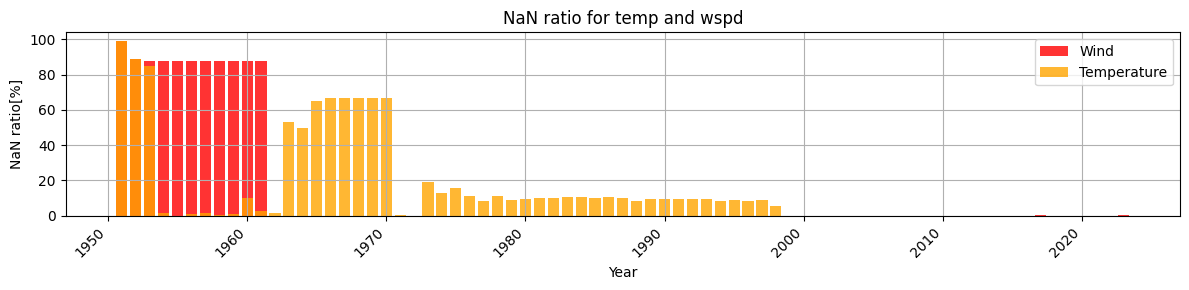

In [16]:
plt.figure(figsize=(12, 3))
plt.bar(range(1951, 2024), null_ratio_wspd, color='red', alpha=0.8, label='Wind')
plt.bar(range(1951, 2024), null_ratio_temp, color='orange', alpha=0.8, label='Temperature')

plt.xlabel('Year')
plt.ylabel('NaN ratio[%]')
plt.title('NaN ratio for temp and wspd')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

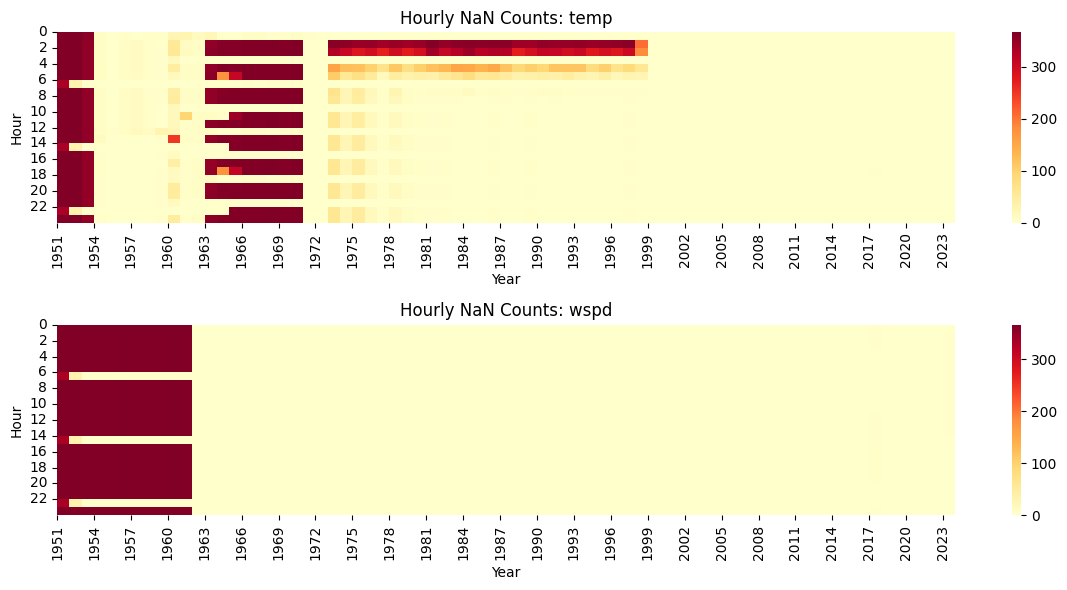

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# 각 연도의 월별 결측치의 개수 분포
sns.heatmap(nan_counts_hourly_df_temp, cmap='YlOrRd', cbar=True, ax=axes[0])
axes[0].set_title('Hourly NaN Counts: temp')
axes[0].set_ylabel('Hour')
axes[0].set_xlabel('Year')
axes[0].set_yticks(ticks=range(0, 24, 2), labels=range(0, 24, 2))
axes[0].set_xticks(ticks=range(0, 73, 3), labels=range(1951, 2024, 3))
# 각 연도의 시간별 결측치의 개수 분포
sns.heatmap(nan_counts_hourly_df_wspd, cmap='YlOrRd', cbar=True, ax=axes[1])
axes[1].set_title('Hourly NaN Counts: wspd')
axes[1].set_ylabel('Hour')
axes[1].set_xlabel('Year')
axes[1].set_yticks(ticks=range(0, 24, 2), labels=range(0, 24, 2))
axes[1].set_xticks(ticks=range(0, 73, 3), labels=range(1951, 2024, 3))

plt.tight_layout()
plt.show()